<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/train_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages and download the data


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

!pip install cmasher as cmr
!pip install torchmetrics

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'cuda'

In [3]:
!pip install --upgrade gdown
import gdown

# Path for the FULL google drive file with turb sim data
# url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

# Path for the smaller turb sim data files (without augmentation)
url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

if not os.path.exists("Image_Cubes_noAugment"):
  gdown.download_folder(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Create training, validation, and test data


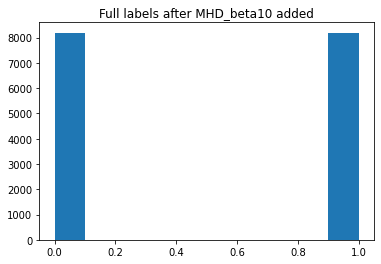

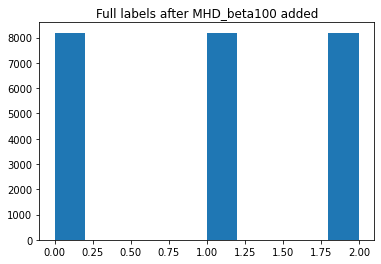

In [5]:
# Specify which simulations we want to train on
fileDirArr = ['MHD_beta1','MHD_beta10','MHD_beta100']

# Specify which "fields" we want access to
field_list = ['density']


# For a given field...
# read in npy files under each file directory
for field in field_list:
    lbl = 0
    for fileDir in fileDirArr:
        filename = f"/data_{fileDir}_{field}_noAugment.npy"
        x = np.load('Image_Cubes_noAugment/'+fileDir + filename, mmap_mode='c') # the images
        x = np.float32(x)

        # assign a class value to each image depending on which        simulation it came from
        # (e.g. 0 for beta = 1, 1 for beta = 10, 2 for beta = 100)
        xshape = x.shape
        y = np.ones(xshape[2])*lbl # label these images by lbl

        # pdb.set_trace()

        if lbl==0:
          x_full = x
          y_full = y
        else:
          x_full = np.concatenate([x_full,x],axis=2)
          y_full = np.concatenate([y_full,y])
          plt.hist(y_full)
          plt.title(f"Full labels after {fileDir} added")
          plt.show()

        lbl+=1

# convert to torch tensors and combine labels, features into TensorDataset
# Need to add a channel column?
x_shape = x_full.shape

# x needs to have a channel column, i.e. x will be in format (N,C,H,W)
# x and y need to have the same first dimension 
x_with_channel = (torch.from_numpy(x_full).permute(2,0,1))
x_channel_shape = x_with_channel.shape
x_with_channel = x_with_channel.reshape(-1,1,x_channel_shape[1],x_channel_shape[2])

#x_full_permute = torch.Tensor(x_with_channel) 
y_full = torch.from_numpy(y_full)
y_full = y_full.type(torch.LongTensor) # needs to be a LongTensor (64) or FloatTensor (32)

# To use full dataset, do this...
full_data = TensorDataset(x_with_channel,y_full)

Generate a well-balanced split of training, validation, and test sets

In [6]:
# split into training (60%), validation (20%), and test (20%) sets
# should eventually replace this in case slices "know" about each other due to spatial correlations
train_data,val_data,test_data = random_split(full_data,[0.6,0.2,0.2])
print(f"Length of Training Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")

Length of Training Data : 14746
Length of Validation Data : 4915
Length of Test Data : 4915


In [7]:
# load batches of training and validation data
# the validation data batch size is twice as large because no backprop is needed

batch_size=64

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


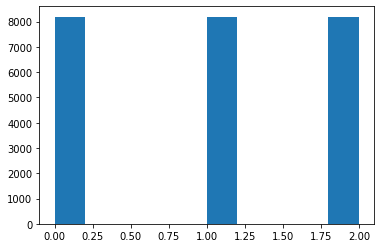

In [8]:
plt.hist(y_full.numpy())
plt.show()

Let's see if the datasets are balanced. There should be equal fractions of beta = 1, 10, and 100

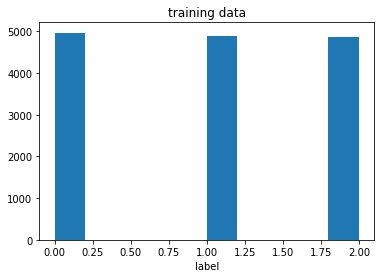

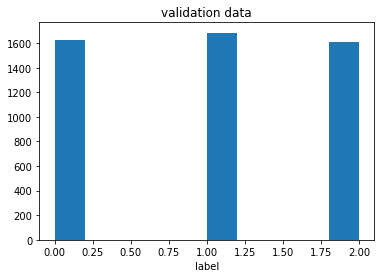

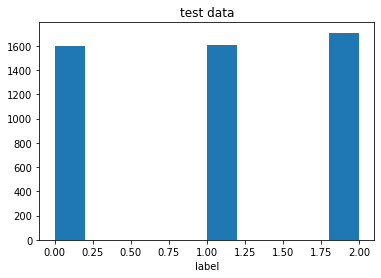

In [10]:
labels_train = []
for images, labels in train_dl:
  labels_train.extend(labels)

labels_valid = []
for images, labels in valid_dl:
  labels_valid.extend(labels)

labels_test = []
for images, labels in test_dl:
  labels_test.extend(labels)

plt.hist(labels_train)
plt.title("training data")
plt.xlabel("label")
plt.show()

plt.hist(labels_valid)
plt.title("validation data")
plt.xlabel("label")
plt.show()

plt.hist(labels_test)
plt.title("test data")
plt.xlabel("label")
plt.show()
         

At this point, its worth it to show a few images and make sure we haven't messed anything up.

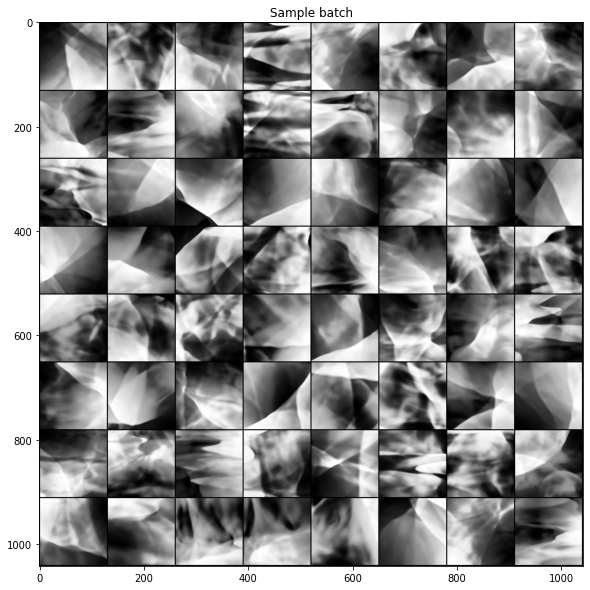

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

"""
figure = plt.figure(figsize=(8, 8))
cols, rows = int(batch_size/2.), int(batch_size/2.)
for i, data in enumerate(train_dl):
    #pdb.set_trace()
    img, label = data 
    img = img.numpy().squeeze(-1)
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    pdb.set_trace()
    if (label[i] == 0):
        plt.imshow(img[i,:,:], cmap="gray")
    if (label[i] == 1):
        plt.imshow(img[i,:,:], cmap="Blues")
    if (label[i] == 2):
        plt.imshow(img[i,:,:], cmap="Greens")
"""
def imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

for i, data in enumerate(train_dl):
    x, y = data  
    imshow(make_grid(x, 8), title = 'Sample batch')
    break  # we need just one batch


## Set up loss function, other metrics to track

In [13]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, Precision, Recall

num_classes = 3
# use torchmetrics
metric_collection = MetricCollection({
    'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
    'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
})

metric_collection_val = metric_collection

tracker_train = MetricTracker(metric_collection)
tracker_val = MetricTracker(metric_collection_val)

loss_arr_train = []
loss_arr_val = []
    #accuracy = Accuracy(task="multiclass", num_classes=3).to(device) 
    #acc = accuracy(y_pred, y_true)
    #return acc.cpu()

def loss_batch(loss_func, prediction, yb, opt=None):
    loss = loss_func(prediction, yb)
 
    #print(f"Metrics on batch: {batch_metrics}")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(yb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, tracker_train, tracker_val):
    for epoch in range(epochs):
        tracker_train.increment()
        model.train()
        train_loss, num = 0, 0
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb, opt)
            tracker_train.update(prediction, yb)

            train_loss += (loss*len)
            num += len

        train_loss = train_loss/num

        #print(f"current training stats={tracker_train.compute()}") 

        tracker_val.increment()
        model.eval()
        with torch.no_grad():
          val_loss, num = 0, 0
          for xb, yb in valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb)
            tracker_val.update(prediction, yb)

            val_loss += (loss*len)
            num += len

        val_loss = val_loss/num    

        print(f"current validation stats={tracker_val.compute()}") 
        
        loss_arr_train.append(train_loss)
        loss_arr_val.append(val_loss)
        print(loss_arr_train)

        # Print out what's happening every epoch
        if epoch % 1 == 0:
          print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| Validation loss: {val_loss:.5f}")
 
   

## Set up and train the model

In [14]:
 # create a CNN using the built-in Sequential class

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,3)
).to(device)

# create a loss function and optimizer

# learning rate and momentum (only for SGD)
lr = 0.001
mmtm = 0.9

loss_fn = nn.CrossEntropyLoss()
#opt = torch.optim.SGD(model.parameters(),
#                            lr=lr,momentum=mmtm)
opt = torch.optim.AdamW(model.parameters(), 
                              weight_decay = 0.01)

# what to track (in addition to training and validation loss)
# use torchmetrics
num_classes = 3
metric_collection = MetricCollection({
    'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
    'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
})

metric_collection_val = metric_collection

tracker_train = MetricTracker(metric_collection)
tracker_val = MetricTracker(metric_collection_val)

In [15]:
# run the model
epochs = 15
fit(epochs, model, loss_fn, opt, train_dl, valid_dl, tracker_train, tracker_val)

current validation stats={'acc': tensor(0.7558, device='cuda:0'), 'prec': tensor(0.8288, device='cuda:0'), 'rec': tensor(0.7533, device='cuda:0')}
[0.6860604660612554]
Epoch: 0 | Train Loss: 0.68606| Validation loss: 0.53603
current validation stats={'acc': tensor(0.6643, device='cuda:0'), 'prec': tensor(0.7617, device='cuda:0'), 'rec': tensor(0.6630, device='cuda:0')}
[0.6860604660612554, 0.34673029788431636]
Epoch: 1 | Train Loss: 0.34673| Validation loss: 0.73966
current validation stats={'acc': tensor(0.9082, device='cuda:0'), 'prec': tensor(0.9101, device='cuda:0'), 'rec': tensor(0.9081, device='cuda:0')}
[0.6860604660612554, 0.34673029788431636, 0.23646669194484266]
Epoch: 2 | Train Loss: 0.23647| Validation loss: 0.25253
current validation stats={'acc': tensor(0.9204, device='cuda:0'), 'prec': tensor(0.9222, device='cuda:0'), 'rec': tensor(0.9214, device='cuda:0')}
[0.6860604660612554, 0.34673029788431636, 0.23646669194484266, 0.17669522188119838]
Epoch: 3 | Train Loss: 0.17670|

## Plot metrics

In [16]:
total_train_metrics = tracker_train.compute_all()
total_val_metrics = tracker_val.compute_all()


def plot_losses(loss_arr_train, loss_arr_val):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(loss_arr_train)+1)

  # plotting parameters
  fs = 20

  plt.plot(num_epochs_run, loss_arr_train, label = f"Training Loss", lw=2)
  plt.plot(num_epochs_run, loss_arr_val, label = f"Validation Loss", lw=2)
  plt.xlabel("Epoch", fontsize=fs)
  plt.legend()
  plt.show()

def plot_other_metrics(total_train_metrics, total_val_metrics, met_list):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(total_train_metrics.get(met_list[0]))+1)

  # plotting parameters
  fs = 20

  for met in met_list:
    train_plot = total_train_metrics.get(met).cpu().numpy()
    val_plot = total_val_metrics.get(met).cpu().numpy()
    plt.plot(num_epochs_run.squeeze(), train_plot, label = f"Training {met}", lw=2)
    plt.plot(num_epochs_run.squeeze(), val_plot, label = f"Validation {met}", lw=2)
    plt.xlabel("Epoch", fontsize=fs)
    plt.legend()
    plt.show()

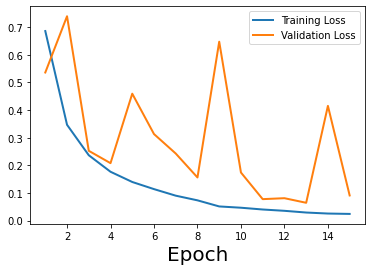

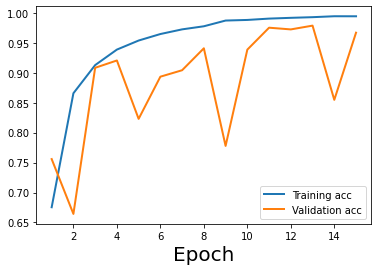

In [17]:
plot_losses(loss_arr_train, loss_arr_val)
met_list = ['acc']
plot_other_metrics(total_train_metrics, total_val_metrics, met_list)

## Save model for later use


In [18]:
torch.save(model.state_dict(),'CNN_Feb13_2023.pt')

## Further analysis

#### Things to play with
1. Accuracy, recall, F-1 score, etc. for each class
2. A few test examples comparing truth to prediction
3. Saliency maps (or other) for a few examples
4. How random and evenly distributed are my training vs validation vs test sets?

5. Do I achieve similar results using magnetic energy density or Alfven speed instead? 


In [19]:
# load the saved model
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,3)
)

model.load_state_dict(torch.load('CNN_Feb13_2023.pt'))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): SiLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): SiLU()
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SiLU()
  (12): AdaptiveAvgPool2d(output_size=4)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=3, bias=True)
)

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ["beta = 1", "beta = 10", "beta = 100"]

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for images, labels in train_dl:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

        y_pred.extend(predictions) # save the prediction
        y_true.extend(labels) # save the truth


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy for class: beta = 1 is 98.5 %
Accuracy for class: beta = 10 is 97.5 %
Accuracy for class: beta = 100 is 100.0 %


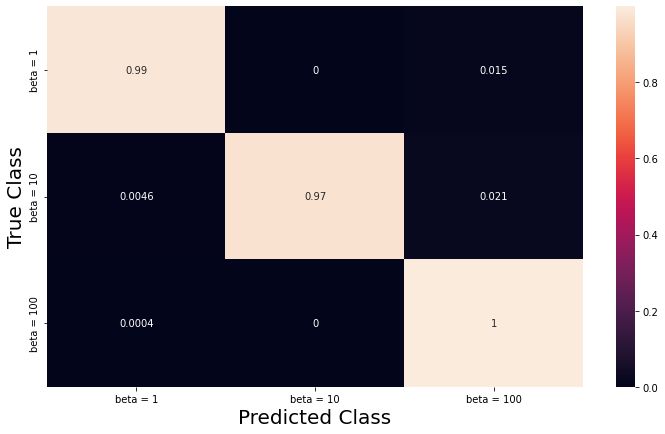

In [21]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Predicted Class",fontsize=20)
plt.ylabel("True Class",fontsize=20)
plt.show()

Let's try to see what the network is picking up on...

## Under construction

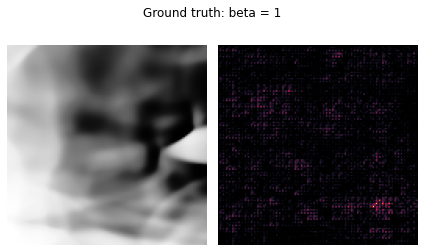

In [25]:
# Try to make a saliency map
# 1. Need to load in an image from one of the data sets
# 2. Evaluate the image with gradients on
# 3. Run backpropagation and store the gradients
# 4. Map the gradients to individual pixels
# 5. Show image
import cmasher as cmr
from numpy import random
model.eval()

id = random.randint(0,20)
for batch_images, batch_labels in valid_dl:  
    image = batch_images[id]    # Reshape them according to your needs.
    label = batch_labels[id]


# requires a 4D tensor, so need to reshape this 3D one
image = image.reshape(1, 1, image.shape[1], image.shape[2])


# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
image.requires_grad_()

# run the model on the image
outputs = model(image)

# Get the index corresponding to the maximum score and the maximum score itself.
pred_max_index = outputs.argmax()
pred_max = outputs[0,pred_max_index]

# backward pass to calculate the gradient
pred_max.backward()

saliency, _ = torch.max(image.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap

plt_image = image.reshape(image.shape[2],image.shape[3])
plt_image = plt_image.detach().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(plt_image,cmap='gray')
ax[0].axis('off')
ax[1].imshow(saliency[0], cmap='cmr.ember')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle(f'Ground truth: {classes[label]}')
plt.show()

These saliency maps are showing me almost nothing. Next step could be to play with Grad-cam, which I've started on but run into problems using a Sequential network (Grad-cam needs access to individual layers?)

In [13]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=d1116ca56486b1d2e4cd31e4f4d0c27e863ca938a073b630606b63685255a826
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [30]:
# taken straight from this link for now: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

#print(model.children)
#target
#target_layers = [model.children()[0]]
# how do you access layers from nn.Sequential??

layer_list = model.children()
print(layer_list)

target_layers = model

dataiter = iter(train_dl)
images, labels = next(dataiter)

input_tensor = images # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

<generator object Module.children at 0x7fcec0a36430>


AxisError: ignored

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(281)
scores, batch_visualizations = CamMultImageConfidenceChange()(input_tensor, 
  inverse_cams, targets, model, return_visualization=True)
visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, perturbation_visualizations = cam_metric(input_tensor, 
  grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,
                                          ROADLeastRelevantFirstAverage,
                                          ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)